# Pipelines subpackage

The `opr.pipelines` subpackage contains ready-to-use pipelines for model inference. In this tutorial we will examine how to build database and utilize `opr.pipelines.localization.LocalizationPipeline` with dynamic objects.

In [1]:
%load_ext autoreload
%autoreload 2

#### Dataset download

You can download the dataset:

- Kaggle:
  - [ITLP Campus Indoor](https://www.kaggle.com/datasets/alexandermelekhin/itlp-campus-indoor)
- Hugging Face:
  - [ITLP Campus Indoor](https://huggingface.co/datasets/OPR-Project/ITLP-Campus-Indoor)


## Create dynamic objects aware database

In [2]:
import os

import faiss
from hydra.utils import instantiate
import numpy as np
from omegaconf import OmegaConf
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from opr.datasets.itlp import ITLPCampus

#### Weights download

You can download the `minkloc3d_nclt.pth` from the HuggingFace model hub:
https://huggingface.co/OPR-Project/PlaceRecognition-NCLT.

```bash
wget https://huggingface.co/OPR-Project/PlaceRecognition-NCLT/resolve/main/minkloc3d_nclt.pth
```


In [3]:
DATABASE_TRACK_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/00_2023-10-25-night/floor_1/"

BATCH_SIZE = 64
NUM_WORKERS = 4
DEVICE = "cuda"

MODEL_CONFIG_PATH = "../configs/model/place_recognition/minkloc3d.yaml"
WEIGHTS_PATH = "../weights/place_recognition/minkloc3d_nclt.pth"

In [4]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

class ToTensorTransform:
    def __init__(self):
        transform_list = [ToTensorV2()]
        self.transform = A.Compose(transform_list)

    def __call__(self, img: np.ndarray):
        """Applies transformations to the given image."""
        return self.transform(image=img)["image"]

db_dataset = ITLPCampus(
    dataset_root=DATABASE_TRACK_DIR,
    sensors=["lidar", "back_cam", "front_cam"],
    mink_quantization_size=0.5,
    load_semantics=True,
    exclude_dynamic_classes=True,
    indoor=True,
    semantic_transform=ToTensorTransform(),
    image_transform=ToTensorTransform(),
)

In [5]:
db_dataset[0].keys()

dict_keys(['idx', 'pose', 'image_front_cam', 'mask_front_cam', 'image_back_cam', 'mask_back_cam', 'pointcloud_lidar_coords', 'pointcloud_lidar_feats'])

In [6]:
db_dataloader = DataLoader(
    db_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=db_dataset.collate_fn,
)

In [7]:
model_config = OmegaConf.load(MODEL_CONFIG_PATH)
model = instantiate(model_config)
model.load_state_dict(torch.load(WEIGHTS_PATH))
model = model.to(DEVICE)
model.eval();

2025-03-21 16:23:47.363 | WARNING  | opr.models.place_recognition.pointmamba:<module>:16 - The 'pointmamba' package is not installed. Please install it manually if neccessary.


In [8]:
descriptors = []
with torch.no_grad():
    for batch in tqdm(db_dataloader):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        final_descriptor = model(batch)["final_descriptor"]
        descriptors.append(final_descriptor.detach().cpu().numpy())

descriptors = np.concatenate(descriptors, axis=0)
descriptors.shape

100%|██████████| 4/4 [00:13<00:00,  3.43s/it]


(241, 256)

In [9]:
index = faiss.IndexFlatL2(descriptors.shape[1])
index.add(descriptors)
print(index.is_trained)
print(index.ntotal)

True
241


In [10]:
faiss.write_index(index, DATABASE_TRACK_DIR + "index.faiss")

## Imports & functions

In [11]:
from time import time

import matplotlib.pyplot as plt
from hydra.utils import instantiate
import numpy as np
from omegaconf import OmegaConf
from scipy.spatial.transform import Rotation

try:
    from geotransformer.utils.registration import compute_registration_error
    from geotransformer.utils.pointcloud import get_transform_from_rotation_translation
except ImportError:
    print("WARNIGN: geotransformer not installed, registration error will not be computed")

from opr.datasets.itlp import ITLPCampus
from opr.pipelines.place_recognition import PlaceRecognitionPipeline
from opr.pipelines.registration import PointcloudRegistrationPipeline
from opr.pipelines.localization import LocalizationPipeline


def pose_to_matrix(pose):
    """From the 6D poses in the [tx ty tz qx qy qz qw] format to 4x4 pose matrices."""
    position = pose[:3]
    orientation_quat = pose[3:]
    rotation = Rotation.from_quat(orientation_quat)
    pose_matrix = np.eye(4)
    pose_matrix[:3,:3] = rotation.as_matrix()
    pose_matrix[:3,3] = position
    return pose_matrix


def compute_error(estimated_pose, gt_pose):
    """For the 6D poses in the [tx ty tz qx qy qz qw] format."""
    estimated_pose = pose_to_matrix(estimated_pose)
    gt_pose = pose_to_matrix(gt_pose)
    error_pose = np.linalg.inv(estimated_pose) @ gt_pose
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = Rotation.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / np.pi
    angle_error = abs(90 - abs(angle_error-90))
    return dist_error, angle_error

def compute_translation_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    gt_trans = gt_pose[:3, 3]
    pred_trans = pred_pose[:3, 3]
    error = np.linalg.norm(gt_trans - pred_trans)
    return error

def compute_rotation_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    gt_rot = Rotation.from_matrix(gt_pose[:3, :3])
    pred_rot = Rotation.from_matrix(pred_pose[:3, :3])
    error = Rotation.inv(gt_rot) * pred_rot
    error = error.as_euler('xyz', degrees=True)
    error = np.linalg.norm(error)
    return error

def compute_absolute_pose_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    rotation_error = compute_rotation_error(gt_pose, pred_pose)
    translation_error = compute_translation_error(gt_pose, pred_pose)
    return rotation_error, translation_error


## Usage example - Place Recognition Pipeline

### Config

In [12]:
DATABASE_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/00_2023-10-25-night/floor_1"
DATABASE_TRACK_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/00_2023-10-25-night/floor_1"
QUERY_TRACK_DIR = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_indoor/01_2023-11-09-twilight/floor_1"

DEVICE = "cuda"

MODEL_CONFIG_PATH = "../configs/model/place_recognition/minkloc3d.yaml"
WEIGHTS_PATH = "../weights/place_recognition/minkloc3d_nclt.pth"

#### Init query dataset

The pipeline infer method accepts an input in the format of dictionary with keys in the following format:
- `"image_{camera_name}"` for images from cameras,
- `"mask_{camera_name}"` for semantic segmentation masks,
- `"pointcloud_lidar_coords"` for pointcloud coordinates from lidar,
- `"pointcloud_lidar_feats"` for pointcloud features from lidar.

The data type of all values are `torch.Tensor`.

You can load and preprocess the data manually, but in this example we will use the `opr.datasets.itlp.ITLPCampus` ` dataset class. 

In [13]:
query_dataset = ITLPCampus(
    dataset_root=QUERY_TRACK_DIR,
    sensors=["lidar", "front_cam", "back_cam"],
    mink_quantization_size=0.5,
    load_semantics=True,
    exclude_dynamic_classes=True,
    indoor=True,
    semantic_transform=ToTensorTransform(),
    image_transform=ToTensorTransform()
)

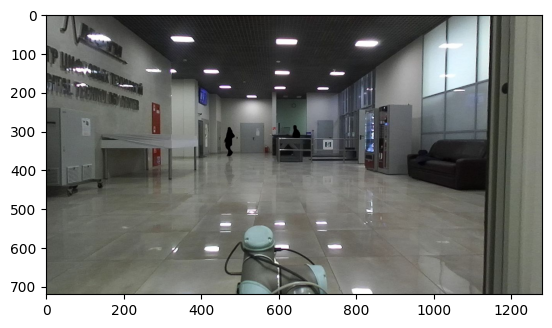

In [14]:
plt.imshow(query_dataset[0]["image_front_cam"].permute(1, 2, 0).numpy())

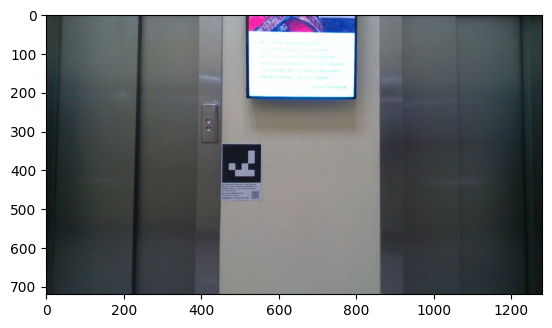

In [15]:
plt.imshow(query_dataset[0]["image_back_cam"].permute(1, 2, 0).numpy())

#### Initialize model

We will use hydra's `instantiate` function to initialize the model. The model is a `MinkLoc3D` - a simple LiDAR-only architecture.

In [16]:
model_config = OmegaConf.load(MODEL_CONFIG_PATH)
model = instantiate(model_config)

#### Initialize pipeline

The minimum requirement to initialize the `PlaceRecognitionPipeline` is that the database directory should contain the `index.faiss` file and the `track.csv` file.

The `index.faiss` file is a Faiss index, which contains the descriptors of the database. The `track.csv` file contains the metadata of the database, including the id and the pose of the descriptors.

The details on how to create the database are described in the [build_database.ipynb](./build_database.ipynb) notebook.

Note that the actual data are not required, as the pipeline will only load the `index.faiss` and the `track.csv` file. This can be useful in the real-world scenario, where the database size is too large to be stored on the local machine.

In [17]:
pipe = PlaceRecognitionPipeline(
    database_dir=DATABASE_DIR,
    model=model,
    model_weights_path=WEIGHTS_PATH,
    device=DEVICE,
)

#### Run inference

In [18]:
sample_data = query_dataset[2]
sample_pose_gt = sample_data.pop("pose")  # removing those keys are not necessary, we just
sample_data.pop("idx")                    # want to simulate that we pass the data without GT information :)
print(f"sample_data.keys() = {sample_data.keys()}")
start = time()
sample_output = pipe.infer(sample_data)
print(time() - start)
print(f"sample_output.keys() = {sample_output.keys()}")
print(f"sample_output['idx'] = {sample_output['idx']}")
print(f"pose = {sample_output['pose']}")
print(f"pose_gt = {sample_pose_gt.numpy()}")
dist_error, angle_error = compute_error(sample_output["pose"], sample_pose_gt.numpy())
print(f"dist_error = {dist_error}, angle_error = {angle_error}")

sample_data.keys() = dict_keys(['image_front_cam', 'mask_front_cam', 'image_back_cam', 'mask_back_cam', 'pointcloud_lidar_coords', 'pointcloud_lidar_feats'])
0.03335452079772949
sample_output.keys() = dict_keys(['idx', 'pose', 'descriptor'])
sample_output['idx'] = 82
pose = [ 1.61565576 -3.10342872 -0.02432048  0.00870435  0.01558649  0.09633875
  0.99518849]
pose_gt = [ 2.359948    0.02083335 -0.08356608  0.02471539  0.01672874 -0.04088648
  0.99871796]
dist_error = 3.2122413304415227, angle_error = 15.849864669941056


## Usage example - Pointcloud Registration Pipeline

### Config

In [19]:
TRACK_DIR = QUERY_TRACK_DIR

REGISTRATION_MODEL_CONFIG_PATH = "../configs/model/registration/geotransformer_kitti.yaml"
REGISTRATION_WEIGHTS_PATH = "../weights/registration/geotransformer_kitti.pth"

### Init model

In [20]:
geotransformer = instantiate(OmegaConf.load(REGISTRATION_MODEL_CONFIG_PATH))

### Init Pipeline

In [21]:
registration_pipe = PointcloudRegistrationPipeline(
    model=geotransformer,
    model_weights_path=REGISTRATION_WEIGHTS_PATH,
    device="cuda",  # the GeoTransformer currently only supports CUDA
    voxel_downsample_size=0.3,  # recommended for geotransformer_kitti configuration
)

### Run inference

In [22]:
i = 3
db_pc = query_dataset[i-1]["pointcloud_lidar_coords"]
query_pc = query_dataset[i]["pointcloud_lidar_coords"]
db_pose = pose_to_matrix(query_dataset[i-1]["pose"])
query_pose = pose_to_matrix(query_dataset[i]["pose"])
# we want to find the transformation from the "database" pose to the "query" pose
gt_transformation = np.linalg.inv(db_pose) @ query_pose

estimated_transformation = registration_pipe.infer(query_pc, db_pc)

print(f"gt_transformation = \n{gt_transformation}\n")
print(f"estimated_transformation = \n{estimated_transformation}\n")

rre, rte = compute_registration_error(gt_transformation, estimated_transformation)
print(f"Relative Rotation Error (RRE) = {rre:0.3f}\nRelative Translation Error (RTE) = {rte:0.3f}\n")

gt_transformation = 
[[ 0.56846755  0.8225701  -0.01493578  0.94120769]
 [-0.82263761  0.56856037  0.00254245 -0.2946486 ]
 [ 0.01058324  0.01084144  0.99988522 -0.03449947]
 [ 0.          0.          0.          1.        ]]

estimated_transformation = 
[[ 0.57134944  0.8206346  -0.01088061  1.0392556 ]
 [-0.8206662   0.57113945 -0.01750014  0.002074  ]
 [-0.00814687  0.01892806  0.9997876   0.0941211 ]
 [ 0.          0.          0.          1.        ]]

Relative Rotation Error (RRE) = 1.187
Relative Translation Error (RTE) = 0.338



In [23]:
print(f"gt_pose = \n{query_pose}")
print(f"optimized_pose = \n{db_pose @ estimated_transformation}")

gt_pose = 
[[ 0.49871748  0.86660328  0.01672219  3.27209187]
 [-0.86537473  0.49891723 -0.04699128 -0.34680817]
 [-0.04906578  0.00896442  0.99875532 -0.16549936]
 [ 0.          0.          0.          1.        ]]
optimized_pose = 
[[ 0.50116276  0.86514196  0.01910505  3.3982731 ]
 [-0.86269501  0.50123073 -0.06726524 -0.06589206]
 [-0.06777002  0.01722902  0.99755217 -0.02633978]
 [ 0.          0.          0.          1.        ]]


## Usage example - Localization Pipeline

Localization pipeline combines the place recognition and the pointcloud registration pipeline.

### Init database dataset

In [24]:
db_dataset = ITLPCampus(
    dataset_root=DATABASE_TRACK_DIR,
    sensors=["lidar", "front_cam", "back_cam"],
    mink_quantization_size=0.5,
    load_semantics=True,
    exclude_dynamic_classes=True,
    indoor=True,
    semantic_transform=ToTensorTransform(),
    image_transform=ToTensorTransform()
)

### Init Localization Pipeline

Here we will use the PlaceRecognition and Registration pipelines that we have initialized in the previous examples.

In [25]:
localization_pipe = LocalizationPipeline(
    place_recognition_pipeline=pipe,
    registration_pipeline=registration_pipe,
    pointclouds_subdir="lidar",
)

### Test the pipeline

In [29]:
import warnings
warnings.filterwarnings("ignore")

PR_MATCH_THRESHOLD = 25.0
pr_matches = []
rre_list = []
rte_list = []
times = []

for i, sample in enumerate(query_dataset):
    print(f"frame {i}")
    gt_pose = sample.pop("pose")
    gt_pose = get_transform_from_rotation_translation(Rotation.from_quat(gt_pose[3:]).as_matrix(), gt_pose[:3])

    start_time = time()
    pipe_out = localization_pipe.infer(sample)
    times.append(time() - start_time)

    db_match_pose = pipe_out["db_match_pose"]
    db_match_pose = get_transform_from_rotation_translation(Rotation.from_quat(db_match_pose[3:]).as_matrix(), db_match_pose[:3])
    estimated_pose = pipe_out["estimated_pose"]
    estimated_pose = get_transform_from_rotation_translation(Rotation.from_quat(estimated_pose[3:]).as_matrix(), estimated_pose[:3])

    _, db_match_distance = compute_registration_error(gt_pose, db_match_pose)
    pr_matched = db_match_distance <= PR_MATCH_THRESHOLD
    pr_matches.append(pr_matched)

    rre, rte = compute_registration_error(gt_pose, estimated_pose)
    rre_list.append(rre)
    rte_list.append(rte)

frame 0
frame 1
frame 2
frame 3
frame 4
frame 5
frame 6
frame 7
frame 8
frame 9
frame 10
frame 11
frame 12
frame 13
frame 14
frame 15
frame 16
frame 17
frame 18
frame 19
frame 20
frame 21
frame 22
frame 23
frame 24
frame 25
frame 26
frame 27
frame 28
frame 29
frame 30
frame 31
frame 32
frame 33
frame 34
frame 35
frame 36
frame 37
frame 38
frame 39
frame 40
frame 41
frame 42
frame 43
frame 44
frame 45
frame 46
frame 47
frame 48
frame 49
frame 50
frame 51
frame 52
frame 53
frame 54
frame 55
frame 56
frame 57
frame 58
frame 59
frame 60
frame 61
frame 62
frame 63
frame 64
frame 65
frame 66
frame 67
frame 68
frame 69
frame 70
frame 71
frame 72
frame 73
frame 74
frame 75
frame 76
frame 77
frame 78
frame 79
frame 80
frame 81
frame 82
frame 83
frame 84
frame 85
frame 86
frame 87
frame 88
frame 89
frame 90
frame 91
frame 92
frame 93
frame 94
frame 95
frame 96
frame 97
frame 98
frame 99
frame 100
frame 101
frame 102
frame 103
frame 104
frame 105
frame 106
frame 107
frame 108
frame 109
frame 110


In [30]:
print(f"Place Recognition R@1 = {np.mean(pr_matches):0.3f}")
print(f"Localization Mean RRE = {np.mean(rre_list):0.3f}")
print(f"Localization Mean RTE = {np.mean(rte_list):0.3f}")

print(f"Localization Median RRE = {np.median(rre_list):0.3f}")
print(f"Localization Median RTE = {np.median(rte_list):0.3f}")

print(f"Mean Time = {(np.mean(times) * 1000):0.2f} ms")

Place Recognition R@1 = 0.904
Localization Mean RRE = 52.712
Localization Mean RTE = 8.245
Localization Median RRE = 10.568
Localization Median RTE = 2.278
Mean Time = 251.61 ms


Place Recognition R@1 = 0.900

Localization Mean RRE = 43.318

Localization Mean RTE = 7.877

Localization Median RRE = 3.817

Localization Median RTE = 0.581

Mean Time = 493.25 ms